
# Análise Comparativa: Traduções Humanas vs IA (Espanhol)

**Métricas atualizadas**:
1. ✅ **BLEU Score** (tradução humana como referência)
2. ✅ **Similaridade de Cosseno** (embeddings em espanhol)
3. ✅ **Overlap de Termos Técnicos** (baseado em frequência de palavras)
4. ✅ **Densidade Léxica** (riqueza vocabular)
5. ✅ **Contagem de Entidades Nomeadas** (NER)
6. ✅ **Diferença no Número de Palavras**
7. ✅ **Proporção de Stop Words**


In [9]:
# Load libs 
import pandas as pd
from pathlib import Path
import spacy
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
from nltk.metrics.distance import edit_distance 
import matplotlib.pyplot as plt
import seaborn as sns
from wordfreq import zipf_frequency
from typing import List, Tuple
from sklearn.feature_extraction.text import TfidfVectorizer
from collections import defaultdict, Counter



In [10]:
# Configurações (sem pasta de originais em inglês)
BASE_DIR = Path.cwd()
HUMAN_TRANS_DIR = BASE_DIR / "Translated by humans (esp)" / "Translated Texts"
LLM_TRANS_DIR = BASE_DIR / "Translated by LLMs (esp)"

# Lista de arquivos (baseado nos nomes dos arquivos humanos)
file_names = [f.name.replace("ESP ", "") for f in HUMAN_TRANS_DIR.glob("*.txt")]
llm_models = ['claude3.5', 'gemini2.0', 'gpt4o']

nlp = spacy.load("es_core_news_sm")
stop_words = nlp.Defaults.stop_words

## Funções de Análise

In [ ]:
def calculate_ter(reference, hypothesis):
    """Calcula o TER (Translation Edit Rate) baseado em edições necessárias"""
    ref_words = reference.split()
    hyp_words = hypothesis.split()
    if not ref_words:
        return 0.0
    return edit_distance(ref_words, hyp_words) / len(ref_words)

def calculate_metrics(human_text, llm_text):
    """Calculates metrics between two Spanish versions"""
    doc_human = nlp(human_text)
    doc_llm = nlp(llm_text)
    
    # Tokens sem stopwords
    tokens_human = [t.text.lower() for t in doc_human if not t.is_stop and t.is_alpha]
    tokens_llm = [t.text.lower() for t in doc_llm if not t.is_stop and t.is_alpha]
    
    # 1. BLEU Score
    bleu = sentence_bleu([tokens_human], tokens_llm)
    
    # 2. Similaridade de Cosseno
    vectorizer = CountVectorizer().fit_transform([human_text, llm_text])
    cosine_sim = cosine_similarity(vectorizer)[0,1]
    
    # 3. Overlap de Termos Técnicos
    human_terms = set(t for t in tokens_human if zipf_frequency(t, 'es') < 4)
    llm_terms = set(t for t in tokens_llm if zipf_frequency(t, 'es') < 4)
    term_overlap = len(human_terms & llm_terms) / max(len(human_terms), 1)
    
    # 4. Densidade Léxica (Lexical Variation)
    lex_density_human = len(set(tokens_human)) / len(tokens_human) if tokens_human else 0
    lex_density_llm = len(set(tokens_llm)) / len(tokens_llm) if tokens_llm else 0
    
    # 5. Entidades Nomeadas
    entities_human = len(list(doc_human.ents))
    entities_llm = len(list(doc_llm.ents))
    
    # 6. Número de Palavras (Word Count)
    word_count_human = len(doc_human)
    word_count_llm = len(doc_llm)
    word_count_diff = abs(word_count_human - word_count_llm) / max(word_count_human, 1)
    
    # 7. Proporção de Stop Words
    stop_ratio_human = sum(1 for t in doc_human if t.is_stop) / len(doc_human) if doc_human else 0
    stop_ratio_llm = sum(1 for t in doc_llm if t.is_stop) / len(doc_llm) if doc_llm else 0
    
    # 8. Palavras-chave (most frequent words)
    keyword_human = [word for word, count in Counter(tokens_human).most_common()]
    keyword_llm = [word for word, count in Counter(tokens_llm).most_common()]
    
    # 9. Overlap de Palavras-Chave
    keyword_overlap = len(set(keyword_human) & set(keyword_llm)) / max(len(set(keyword_human)), 1)
    
    # 10. TER (Translation Edit Rate)
    ter_score = calculate_ter(human_text, llm_text)
    
    return {
        'BLEU': bleu,
        'Cosine_Similarity': cosine_sim,
        'Technical_Term_Overlap': term_overlap,
        'Keyword_Overlap': keyword_overlap,
        'Lexical_Density_Human': lex_density_human,
        'Lexical_Density_LLM': lex_density_llm,
        'Entities_Human': entities_human,
        'Entities_LLM': entities_llm,
        'Word_Count_Human': word_count_human,
        'Word_Count_LLM': word_count_llm,
        'Word_Count_Diff': word_count_diff,
        'Stop_Ratio_Human': stop_ratio_human,
        'Stop_Ratio_LLM': stop_ratio_llm,
        'TER_Score': ter_score,
        'Top_Keywords_Human': keyword_human,
        'Top_Keywords_LLM': keyword_llm
    }

In [25]:
def generate_results():
    """Generates a dataframe with all comparisons"""
    results = []
    
    for file in file_names:
        human_text = (HUMAN_TRANS_DIR / f"ESP {file}").read_text(encoding='utf-8')
        
        for model in llm_models:
            llm_text = (LLM_TRANS_DIR / model / "Translated Texts" / f"ESP {file}").read_text(encoding='utf-8')
            
            metrics = calculate_metrics(human_text, llm_text)
            metrics.update({
                'File': file,
                'Model': model
            })
            results.append(metrics)
    
    return pd.DataFrame(results)

## Visualizações Consolidadas

# Gerar e mostrar resultados

/tmp/ipykernel_185504/3148237672.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=df, x='Model', y='BLEU', palette='Blues')


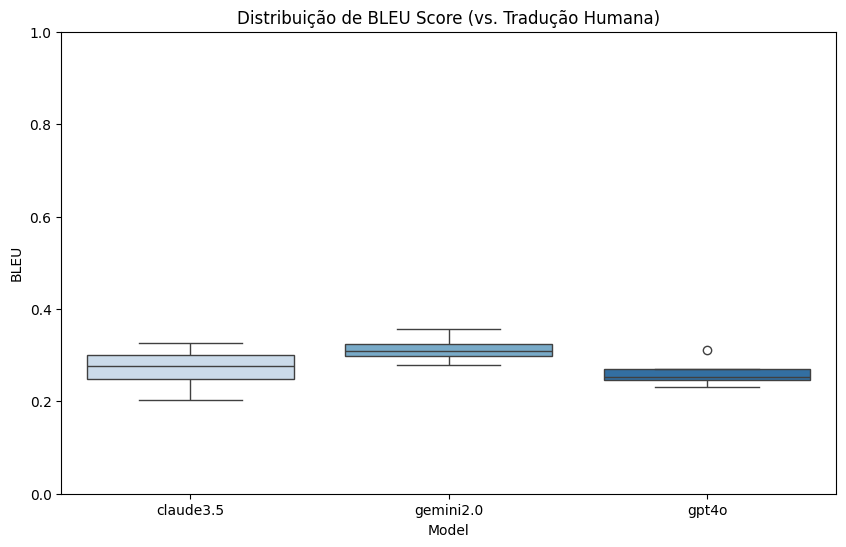

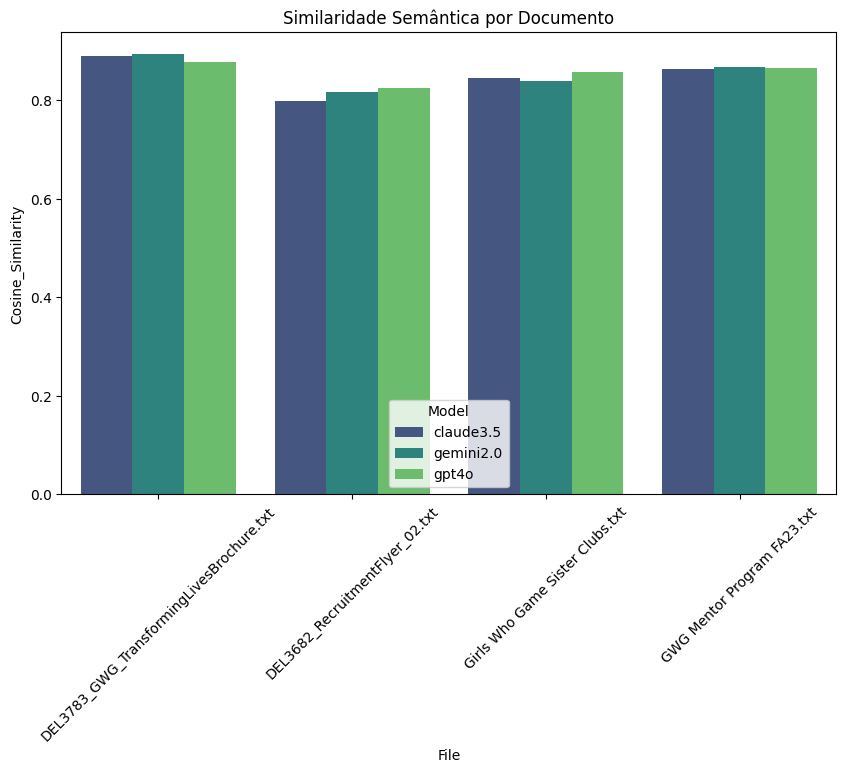


🔍 Métricas Médias por Modelo:


,BLEU,Cosine_Similarity,Technical_Term_Overlap,TER_Score,Keyword_Overlap,Lexical_Density_Human,Lexical_Density_LLM
Model,,,,,,,
claude3.5,0.270787,0.849102,0.484550,0.455545,0.475000,0.679897,0.669692
gemini2.0,0.313088,0.854141,0.522029,0.439046,0.500000,0.679897,0.664674
gpt4o,0.262053,0.856163,0.506658,0.487210,0.425000,0.679897,0.655208


In [29]:
df = generate_results()

# Gráfico 1: Comparação de BLEU Score por Modelo
plt.figure(figsize=(10, 6))
sns.boxplot(data=df, x='Model', y='BLEU', palette='Blues')
plt.title('Distribuição de BLEU Score (vs. Tradução Humana)')
plt.ylim(0, 1)
plt.show()

# Gráfico 2: Similaridade de Cosseno
plt.figure(figsize=(10, 6))
sns.barplot(data=df, x='File', y='Cosine_Similarity', hue='Model', palette='viridis')
plt.xticks(rotation=45)
plt.title('Similaridade Semântica por Documento')
plt.show()

# Tabela Resumo
print("\n🔍 Métricas Médias por Modelo:")
summary_df = df.groupby('Model')[['BLEU', 'Cosine_Similarity', 'Technical_Term_Overlap', 'TER_Score', 'Keyword_Overlap', 'Lexical_Density_Human'
,'Lexical_Density_LLM']].mean()
display(summary_df.style.background_gradient(cmap='Greens', axis=0))

# Exportar
df.to_csv(BASE_DIR / "Results" / "comparison_human_vs_llm.csv", index=False)

### Key-words

In [30]:
# Add custom words to exclude (common in academic/technical texts)
CUSTOM_EXCLUDE_WORDS = {"as", "stem", "flip", "who", "girls", "game", "chicas", "juegan", "gwg"}

def extract_keywords(text, top_n=5) -> List[Tuple[str, float]]:
    """Extract top keywords from text using TF-IDF with custom exclusions"""
    doc = nlp(text)
    
    cleaned_text = ' '.join([
        token.text.lower() 
        for token in doc 
        if not token.is_stop 
        and token.is_alpha
        and token.text.lower() not in CUSTOM_EXCLUDE_WORDS
    ])
    
    tfidf = TfidfVectorizer(max_features=50)
    tfidf_matrix = tfidf.fit_transform([cleaned_text])
    
    feature_names = tfidf.get_feature_names_out()
    scores = tfidf_matrix.toarray()[0]
    
    keywords = [(feature_names[i], scores[i]) 
               for i in scores.argsort()[-top_n:][::-1]]
    
    return keywords

def format_keywords(keywords: List[Tuple[str, float]]) -> str:
    """Format keywords as bullet points with scores"""
    return '\n'.join([
        f"• {word} ({score:.3f})" 
        for word, score in keywords
    ])

def compare_keywords():
    """Generate keyword comparison table for all files and models"""
    keyword_data = defaultdict(dict)
    
    for file in file_names:
        human_text = (HUMAN_TRANS_DIR / f"ESP {file}").read_text(encoding='utf-8')
        human_keywords = extract_keywords(human_text)
        keyword_data[file]['Human'] = format_keywords(human_keywords)
        
        for model in llm_models:
            llm_text = (LLM_TRANS_DIR / model / "Translated Texts" / f"ESP {file}").read_text(encoding='utf-8')
            llm_keywords = extract_keywords(llm_text)
            keyword_data[file][model] = format_keywords(llm_keywords)
    
    rows = []
    for file in keyword_data:
        row = {'File': file}
        for model in ['Human'] + llm_models:
            row[f'{model}_keywords'] = keyword_data[file][model]
        rows.append(row)
    
    return pd.DataFrame(rows)

keyword_df = compare_keywords()
print("\n📚 Top 5 Keywords Comparison (with TF-IDF scores):")
display(keyword_df.style.set_properties(**{
    'white-space': 'pre-wrap',
    'text-align': 'left',
    'font-family': 'monospace'
}).set_table_styles([
    {'selector': 'th', 'props': [('text-align', 'left')]},
]))

keyword_df.to_csv(BASE_DIR / "Results" / "keyword_comparison.csv", index=False)


📚 Top 5 Keywords Comparison (with TF-IDF scores):


,File,Human_keywords,claude3.5_keywords,gemini2.0_keywords,gpt4o_keywords
0,DEL3783_GWG_TransformingLivesBrochure.txt,• programa (0.392) • habilidades (0.314) • mujeres (0.314) • dell (0.235) • recursos (0.196),• programa (0.401) • habilidades (0.281) • aprendizaje (0.241) • dell (0.241) • construir (0.201),• programa (0.403) • habilidades (0.323) • estudiantes (0.242) • dell (0.242) • mujeres (0.202),• programa (0.410) • estudiantes (0.410) • habilidades (0.298) • dell (0.224) • aprendizaje (0.186)
1,DEL3682_RecruitmentFlyer_02.txt,• computación (0.315) • habilidades (0.315) • oportunidades (0.236) • club (0.236) • mujeres (0.236),• estudiantes (0.306) • computación (0.306) • habilidades (0.306) • clubes (0.229) • crear (0.229),• habilidades (0.327) • estudiantes (0.327) • clubes (0.245) • oportunidades (0.245) • utilizando (0.163),• estudiantes (0.356) • computación (0.285) • habilidades (0.285) • américa (0.214) • ciencias (0.214)
2,Girls Who Game Sister Clubs.txt,• clubes (0.685) • hermanas (0.440) • club (0.196) • estudiantes (0.196) • perspectivas (0.147),• clubes (0.690) • hermanos (0.372) • club (0.212) • programa (0.212) • estudiantes (0.159),• clubes (0.691) • hermanos (0.395) • programa (0.197) • estudiantes (0.197) • club (0.197),• clubes (0.690) • hermanos (0.394) • club (0.197) • estudiantes (0.197) • programa (0.197)
3,GWG Mentor Program FA23.txt,• orientación (0.333) • mentoría (0.333) • mentoras (0.266) • programa (0.266) • júnior (0.266),• liderazgo (0.541) • mentoría (0.361) • programa (0.240) • actividad (0.180) • junior (0.180),• liderazgo (0.495) • mentoría (0.309) • junior (0.248) • mentor (0.248) • programa (0.248),• liderazgo (0.427) • mentor (0.305) • mentoría (0.305) • programa (0.244) • junior (0.244)


In [31]:
def compare_word_counts():
    """Compares the word count between human translations and LLMs"""
    word_count_data = []

    for file in file_names:
        human_text = (HUMAN_TRANS_DIR / f"ESP {file}").read_text(encoding='utf-8')
        human_word_count = len(human_text.split())
        
        for model in llm_models:
            llm_text = (LLM_TRANS_DIR / model / "Translated Texts" / f"ESP {file}").read_text(encoding='utf-8')
            llm_word_count = len(llm_text.split())
            
            word_count_data.append({
                'File': file,
                'Human_Word_Count': human_word_count,
                'Model': model,
                'LLM_Word_Count': llm_word_count,
                'Difference': abs(human_word_count - llm_word_count)
            })
    
    return pd.DataFrame(word_count_data)

word_count_df = compare_word_counts()
print("\n📊 Comparação do Número de Palavras:")
display(word_count_df)

word_count_df.to_csv(BASE_DIR / "Results" / "word_count_comparison.csv", index=False)


📊 Comparação do Número de Palavras:


,File,Human_Word_Count,Model,LLM_Word_Count,Difference
0,DEL3783_GWG_TransformingLivesBrochure.txt,814,claude3.5,760,54
1,DEL3783_GWG_TransformingLivesBrochure.txt,814,gemini2.0,819,5
2,DEL3783_GWG_TransformingLivesBrochure.txt,814,gpt4o,793,21
3,DEL3682_RecruitmentFlyer_02.txt,326,claude3.5,303,23
4,DEL3682_RecruitmentFlyer_02.txt,326,gemini2.0,307,19
5,DEL3682_RecruitmentFlyer_02.txt,326,gpt4o,331,5
6,Girls Who Game Sister Clubs.txt,377,claude3.5,353,24
7,Girls Who Game Sister Clubs.txt,377,gemini2.0,370,7
8,Girls Who Game Sister Clubs.txt,377,gpt4o,375,2
9,GWG Mentor Program FA23.txt,358,claude3.5,359,1
